<span style="font-size:large;">
<div style="text-align: right">CSTS-UH 1078 <b>Networks</b><br/>
Faculty: <b>Moses Boudourides</b><br/>
Fall Semester 2019<br/>
New York University Abu Dhabi</div>

## <span style="color:red">EXPERIMENT 7</span>
# <span style="color:green">Recommendation Systems and Co-Recommendation Networks</span>

### Some common *datasets for recommendation systems*:
- BX-Dump https://github.com/bigsnarfdude/guide-to-data-mining/tree/master/BX-Dump [used here]
- Bookcrossing http://www2.informatik.uni-freiburg.de/~cziegler/BX/
- SNAP Amazon reviews https://snap.stanford.edu/data/web-Amazon.html
- MovieLens https://grouplens.org/
- Or anywhere else you might be able to locate data similar to the ones processed in this notebook.

#### Here we are working with the first dataset of BX-Dump Book recommendations.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.drawing.nx_agraph import to_agraph 
import matplotlib.pyplot as plt
from pylab import hist
import random
from collections import Counter
import operator
import itertools
import cPickle as pickle
import warnings
warnings.filterwarnings("ignore")

In [20]:
import os
os.chdir("/Volumes/LaCie/WorkPlaces/Python Projects 2/2 NYUAD Networks/CourseNotebooks/Utilities/")

books = pd.read_csv('BXDump/BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
users = pd.read_csv('BXDump/BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']
ratings = pd.read_csv('BXDump/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

Skipping line 6451: expected 8 fields, saw 9
Skipping line 43666: expected 8 fields, saw 10
Skipping line 51750: expected 8 fields, saw 9

Skipping line 92037: expected 8 fields, saw 9
Skipping line 104318: expected 8 fields, saw 9
Skipping line 121767: expected 8 fields, saw 9

Skipping line 144057: expected 8 fields, saw 9
Skipping line 150788: expected 8 fields, saw 9
Skipping line 157127: expected 8 fields, saw 9
Skipping line 180188: expected 8 fields, saw 9
Skipping line 185737: expected 8 fields, saw 9

Skipping line 209387: expected 8 fields, saw 9
Skipping line 220625: expected 8 fields, saw 9
Skipping line 227932: expected 8 fields, saw 11
Skipping line 228956: expected 8 fields, saw 10
Skipping line 245932: expected 8 fields, saw 9
Skipping line 251295: expected 8 fields, saw 9
Skipping line 259940: expected 8 fields, saw 9
Skipping line 261528: expected 8 fields, saw 9



### 1. Ratings

In [3]:
print ratings.shape
print list(ratings.columns)
print sorted(list(ratings.bookRating.unique()))
ratings.head()

(1149779, 3)
['userID', 'ISBN', 'bookRating']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


,userID,ISBN,bookRating
0,276726,0155061224,5
1,276727,0446520802,0
2,276729,052165615X,3
3,276729,0521795028,6
4,276733,2080674722,0


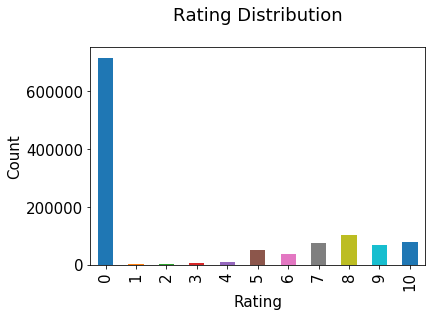

In [4]:
plt.rc("font", size=15)
ratings.bookRating.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

### 2. Users

In [5]:
print users.shape
users.head()

(278857, 3)


,userID,Location,Age
0,2,"stockton, california, usa",18
1,3,"moscow, yukon territory, russia",\N
2,4,"porto, v.n.gaia, portugal",17
3,5,"farnborough, hants, united kingdom",\N
4,6,"santa monica, california, usa",61


#### 2.1 Users Age

In [6]:
users = users.drop(users[users.Age=='\N'].index)
users_age=[int(x) for x in users.Age.tolist() if int(x)<100]
# res = list(sorted(Counter(users_age), key=Counter(users_age).__getitem__, reverse=True))
# # for j in range(100):
# for i in res:
# #         if i==j:
#     print i,Counter(users_age)[i]

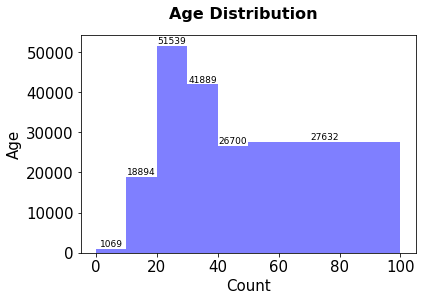

In [7]:
ax = plt.subplot(111)
bins=[0, 10, 20, 30, 40, 50, 100]
hh=ax.hist(users_age, bins=bins,align='mid',color="blue", alpha=0.5); #range=[10,284],range=[0,100],
ntei="Age Distribution"
for p in ax.patches:
    ax.annotate("%i" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points',fontsize=9)
t1=plt.suptitle(ntei,fontsize=16,fontweight='bold');
t1=plt.xlabel("Count", fontsize=15);
t1=plt.ylabel("Age", fontsize=15);

In [8]:
uc=Counter(users_age)
lc=[]
xc=[]
for k in sorted(uc):
    xc.append(k)
    lc.append(uc[k])
#     print k,uc[k]

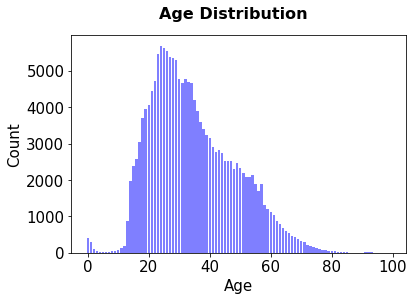

In [9]:
ax = plt.subplot(111)
hh=ax.bar(xc, lc,color="blue", alpha=0.5); #range=[10,284],range=[0,100],
ntei="Age Distribution"
# for p in ax.patches:
#     ax.annotate("%i" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points',fontsize=9)
t1=plt.suptitle(ntei,fontsize=16,fontweight='bold');
t1=plt.xlabel("Age", fontsize=15);
t1=plt.ylabel("Count", fontsize=15);

### 3. Books

In [10]:
print books.shape
print list(books.columns)
books.head()

(271359, 8)
['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']


,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
1,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
3,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
4,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...


### 4. Recommendations Based on Book Rating Counts

#### 4.1 Book Rating

In [11]:
rating_count = pd.DataFrame(ratings.groupby('ISBN')['bookRating'].count())
rating_count.sort_values('bookRating', ascending=False).head()

,bookRating
ISBN,
0971880107,2502
0316666343,1295
0385504209,883
0060928336,732
0312195516,723


#### 4.2 Most Rated Books

In [12]:
most_rated_books = pd.DataFrame(['0971880107', '0316666343', '0385504209', '0060928336', '0312195516'], index=np.arange(5), columns = ['ISBN'])
most_rated_books_summary = pd.merge(most_rated_books, books, on='ISBN')
most_rated_books_summary

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...
1,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...
2,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...
3,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...
4,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...


### 5. Recommendations Based on Correlations

In [13]:
average_rating = pd.DataFrame(ratings.groupby('ISBN')['bookRating'].mean())
average_rating['ratingCount'] = pd.DataFrame(ratings.groupby('ISBN')['bookRating'].count())
average_rating.sort_values('ratingCount', ascending=False).head()

,bookRating,ratingCount
ISBN,,
0971880107,1.019584,2502
0316666343,4.468726,1295
0385504209,4.652322,883
0060928336,3.448087,732
0312195516,4.334716,723


#### To ensure statistical significance, users with less than 200 ratings, and books with less than 100 ratings are excluded

In [14]:
counts1 = ratings['userID'].value_counts()
ratings = ratings[ratings['userID'].isin(counts1[counts1 >= 200].index)]
counts = ratings['bookRating'].value_counts()
ratings = ratings[ratings['bookRating'].isin(counts[counts >= 100].index)]

### 5.1 The Rating Matrix

In [15]:
ratings_pivot = ratings.pivot(index='userID', columns='ISBN').bookRating
userID = ratings_pivot.index
ISBN = ratings_pivot.columns
print(ratings_pivot.shape)
ratings_pivot.head()

(905, 207699)


ISBN,0330299891,0375404120,0586045007,9022906116,9032803328,9044922564,9044922572,9044922718,9044923161,904492401X,...,THEFLYINGACE,UNGRANDHOMMED,X000000000,"YOUTELLEM,AND",ZR903CX0003,"\0432534220\""""","\2842053052\""""",b00005wz75,cn108465,cn113107
userID,,,,,,,,,,,,,,,,,,,,,
254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Books correlated with one of the most rated books

In [16]:
book_isbn='0385504209'
selectedbook=most_rated_books_summary.loc[most_rated_books_summary['ISBN'] == book_isbn]['bookTitle'].values[0]
selectedbook

u'The Da Vinci Code'

In [17]:
selectedbook_ratings = ratings_pivot[book_isbn]
similar_to_selectedbook = ratings_pivot.corrwith(selectedbook_ratings)
corr_selectedbook = pd.DataFrame(similar_to_selectedbook, columns=['pearsonR'])
corr_selectedbook.dropna(inplace=True)
corr_summary = corr_selectedbook.join(average_rating['ratingCount'])
corr_summary[corr_summary['ratingCount']>=300].sort_values('pearsonR', ascending=False).head(10)

,pearsonR,ratingCount
ISBN,,
0385504209,1.000000,883
044651652X,0.524773,368
044022165X,0.434780,386
006101351X,0.368629,364
0312278586,0.367703,474
0440222656,0.350079,420
0060987103,0.349445,326
0439064872,0.346980,351
0671021001,0.329035,468


#### Find out  from ISBN the names of the books correlated with the selected book

In [18]:
lisbn=corr_summary[corr_summary['ratingCount']>=300].sort_values('pearsonR', ascending=False).index.tolist()[:10]
books_corr_to_selectedbook = pd.DataFrame(lisbn,index=np.arange(10), columns=['ISBN'])
corr_books = pd.merge(books_corr_to_selectedbook, books, on='ISBN')
corr_books

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...
1,044651652X,The Bridges of Madison County,Robert James Waller,1992,Warner Books,http://images.amazon.com/images/P/044651652X.0...,http://images.amazon.com/images/P/044651652X.0...,http://images.amazon.com/images/P/044651652X.0...
2,044022165X,The Rainmaker,JOHN GRISHAM,1996,Dell,http://images.amazon.com/images/P/044022165X.0...,http://images.amazon.com/images/P/044022165X.0...,http://images.amazon.com/images/P/044022165X.0...
3,006101351X,The Perfect Storm : A True Story of Men Agains...,Sebastian Junger,1998,HarperTorch,http://images.amazon.com/images/P/006101351X.0...,http://images.amazon.com/images/P/006101351X.0...,http://images.amazon.com/images/P/006101351X.0...
4,0312278586,The Nanny Diaries: A Novel,Emma McLaughlin,2002,St. Martin's Press,http://images.amazon.com/images/P/0312278586.0...,http://images.amazon.com/images/P/0312278586.0...,http://images.amazon.com/images/P/0312278586.0...
5,0440222656,The Horse Whisperer,Nicholas Evans,1996,Dell,http://images.amazon.com/images/P/0440222656.0...,http://images.amazon.com/images/P/0440222656.0...,http://images.amazon.com/images/P/0440222656.0...
6,0060987103,Wicked: The Life and Times of the Wicked Witch...,Gregory Maguire,1996,Regan Books,http://images.amazon.com/images/P/0060987103.0...,http://images.amazon.com/images/P/0060987103.0...,http://images.amazon.com/images/P/0060987103.0...
7,0439064872,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,2000,Scholastic,http://images.amazon.com/images/P/0439064872.0...,http://images.amazon.com/images/P/0439064872.0...,http://images.amazon.com/images/P/0439064872.0...
8,0671021001,She's Come Undone (Oprah's Book Club),Wally Lamb,1998,Pocket,http://images.amazon.com/images/P/0671021001.0...,http://images.amazon.com/images/P/0671021001.0...,http://images.amazon.com/images/P/0671021001.0...
9,0345370775,Jurassic Park,Michael Crichton,1999,Ballantine Books,http://images.amazon.com/images/P/0345370775.0...,http://images.amazon.com/images/P/0345370775.0...,http://images.amazon.com/images/P/0345370775.0...


### 6. Multipartite Graphs of Rated Books

In [19]:
books=books[[u'ISBN', u'bookTitle', u'bookAuthor', u'yearOfPublication']]
df = pd.merge(ratings, books, on='ISBN')
df.dropna(inplace=True)
excl=[0,u'0',u'2020', u'2024', u'2030', u'2037', u'DK Publishing Inc', u'Gallimard']
exc=['Not Applicable (Na )']
df=df[~df['yearOfPublication'].isin(excl)]
df=df[~df['bookAuthor'].isin(exc)]
df = df.replace(to_replace= r'\\', value= '', regex=True)
df['bookAuthor'] = df['bookAuthor'].astype('unicode')

authors=df.bookAuthor.unique()
booktitles=df.bookTitle.unique()
users=df.userID.unique()

print "Total number of rows =",len(df)
print "Total number of Authors =",len(authors) 
print "Total number of Book Titles =",len(booktitles) 
print "Total number of Users =",len(users) 
df[:50] #.head()

Total number of rows = 483686
Total number of Authors = 66436
Total number of Book Titles = 158443
Total number of Users = 905


,userID,ISBN,bookRating,bookTitle,bookAuthor,yearOfPublication
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994
5,16795,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994
6,24194,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994
7,25981,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994
8,26535,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994
9,28204,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994


In [20]:
def first_diagn(G,name):
    n=len(G.nodes())
    m=len(G.edges())
    if nx.is_bipartite(G)==True:
        print "The graph of %s is a bipartite graph and it has %i nodes and %i edges" %(name,n,m) 
    else: 
        print "The graph of %s has %i nodes and %i edges" %(name,n,m) 
        
def graph_connectedness_check(G):
    giant = max(nx.connected_component_subgraphs(G), key=len)
    if nx.is_connected(G)==True:
        print "This graph is connected"
    else:
        print "This graph is not connected and the number of connected components =", nx.number_connected_components(G)
        print "The largest conected component of this graph has %i nodes and %i edges" %(len(giant.nodes()),len(giant.edges()))

In [21]:
medges=[]
gu=df[['userID','bookAuthor']].groupby('userID')
for user,data in gu:
    auths=data.loc[data['userID']==user,'bookAuthor'].tolist()
    for auth in auths:
        medges.append((user,auth))
print len(medges),len(set(medges))
H = nx.Graph()
for k,v in dict(Counter(medges)).items():
    H.add_edge(k[0],k[1],weight=v)
gau=[n for n in H.nodes() if type(n)!=int]

# Detect and remove nodes with non-ascii characters
nas=[]
for a in gau:
    for c in a:
        if ord(c) < 0 or ord(c) > 127:
            if a not in nas:
                nas.append(a)
H.remove_nodes_from(nas)

gus=[n for n in H.nodes() if type(n)==int]
gau=[n for n in H.nodes() if type(n)!=int]
name="Books dataset"
first_diagn(H,name)
print "The %i nodes of this graph are:" %len(H.nodes())
print "%i users (raters) and" %len(gus)
print "%i (rated) authors" %len(gau)
graph_connectedness_check(H)

483686 334276
The graph of Books dataset is a bipartite graph and it has 66822 nodes and 333514 edges
The 66822 nodes of this graph are:
905 users (raters) and
65917 (rated) authors
This graph is connected


**It is impractical to hope to plot such a large graph in NetworkX. Instead of the whole graph, we are going to plot egocentric subgraphs around authors or users with moderately large degrees. These authors are chosen randomly, though one should be able to predefine such authors or users.**

In [22]:
# The code below runs very very slowly because the graph is huge (334446 edges!)
# So I suggest that you shouldn't bother with it (unless you're using a supercomputer!)

# edge_width=[H[u][v]['weight'] for u,v in H.edges()]
# # elabels = nx.get_edge_attributes(Gw,'weight')
# edge_width=[w for w in edge_width] 
# # [math.log(1+w) for w in edge_width]
# # [3*w for w in edge_width] 

# figsize=(14,10)
# pos=nx.spring_layout(H,1.)  #graphviz_layout(H) #
# node_color="#ffb3b3"
# # node_border_color="grey"
# edge_color="#668cff"
# G=H
# labels={}
# for n in G.nodes():
#     labels[n]=''
# node_size={}
# for n in G.nodes():
#     if n in gus:
#         node_size[n]=rn0[i]
#     else:
#         node_size[n]=50
# plt.figure(figsize=figsize);
# # nodes = nx.draw_networkx_nodes(G, pos,node_color=node_color,node_size=100)
# nx.draw_networkx_nodes(G,pos=pos,nodelist=gus,node_color='b',node_size=node_size,font_size=20,alpha=0.4);
# nx.draw_networkx_nodes(G,pos=pos,nodelist=gau,node_color='lime',node_shape="s",node_size=node_size,font_size=20,alpha=0.6);
# # nodes.set_edgecolor(node_border_color)
# nx.draw_networkx_edges(G, pos, edge_color=edge_color,width=edge_width) #,a=0.8)
# nx.draw_networkx_labels(G, pos)
# # nx.draw_networkx_edge_labels(G,pos,edge_labels=elabels);
# plt.axis('off');
# # yoffset = {}
# # y_off = -10 #0.05  # offset on the y axis
# # for k, v in pos.items():
# #     yoffset[k] = (v[0], v[1]+y_off)
# # nx.draw_networkx_labels(G, yoffset,font_size=14);
# sst="The bipartite graph of rating users (%i blue colored circles) and rated books (%i lime colored squares)" %len(gus),len(gau)
# plt.title(sst,fontsize=20);
# plt.margins(x=0.3, y=0.1) 

### Users rating an author

In [23]:
while True:
    n0=random.choice(gau)
    if H.degree(n0)<50 and H.degree(n0)>15:
        break
print n0,H.degree(n0)

Larry Burkett 24


In [24]:
# # Otherwise, one may take a particular author. For example:

# n0 = "Tabitha King"
H.degree('Tabitha King')

29

In [25]:
# This dictionary has keys n0's neighbors (i.e., rating users) 
# and values their average ratings

rn0={}
gu0=df.loc[df.bookAuthor==n0].groupby(['userID','bookRating'])
for name,group in gu0:
    l=group.bookRating.tolist()
    rn0[name[0]] = sum(l) / float(len(l))
rn0

{35857: 0.0,
 35859: 0.0,
 51883: 0.0,
 55492: 0.0,
 87746: 0.0,
 93363: 8.0,
 95193: 0.0,
 98741: 0.0,
 127233: 0.0,
 133689: 0.0,
 135149: 0.0,
 140036: 0.0,
 162639: 8.0,
 179744: 0.0,
 189516: 0.0,
 204864: 0.0,
 225595: 8.0,
 228998: 0.0,
 230522: 0.0,
 236959: 0.0,
 238961: 0.0,
 245827: 0.0,
 251613: 0.0,
 277427: 9.0}

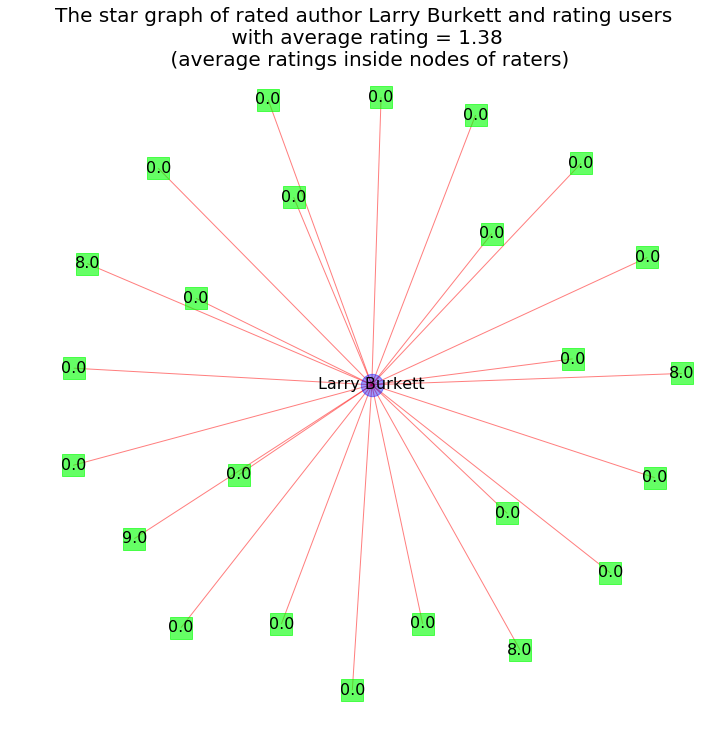

In [26]:
H0=H.subgraph(list(H.neighbors(n0))+[n0])
ara=sum(rn0.values())/float(len(rn0))
labels={}
for i in H0.nodes():
    if i!=n0:
        labels[i]=rn0[i]
    else:
        labels[i]=i
fig = plt.figure(figsize=(12,12))
pos=graphviz_layout(H0)
nx.draw_networkx_nodes(H0,pos=pos,nodelist=[n0],node_color='b',node_size=500,font_size=20,alpha=0.4);
nx.draw_networkx_nodes(H0,pos=pos,nodelist=list(H.neighbors(n0)),node_color='lime',node_shape="s",node_size=500,font_size=20,alpha=0.6);
nx.draw_networkx_edges(H0,pos=pos,edge_color='r',alpha=0.5);
nx.draw_networkx_labels(H0,pos=pos,labels=labels,font_size=16);
sst="The star graph of rated author %s and rating users \n with average rating = %.2f \n (average ratings inside nodes of raters)" %(n0,ara)
fig.suptitle(sst,x=0.5, y=.95, fontsize=20);
plt.axis('off');

### Authors rated by a user

In [27]:
while True:
    n1=random.choice(gus)  
    rn1={}
    gu1=df.loc[df.userID==n1].groupby(['bookAuthor','bookRating'])
    for name,group in gu1:
        l=group.bookRating.tolist()
        rn1[name[0]] = sum(l) / float(len(l))
    ara=sum(rn1.values())/float(len(rn1))
    if ara!=0 and H.degree(n1)>15 and H.degree(n1)<50:
        break
print n1,H.degree(n1) 

154176 43


In [28]:
# This dictionary has keys n1's neighbors (i.e., rated authors) 
# and values their average ratings

rn1={}
gu1=df.loc[df.userID==n1].groupby(['bookAuthor','bookRating'])
for name,group in gu1:
    l=group.bookRating.tolist()
    rn1[name[0]] = sum(l) / float(len(l))
rn1

{u'Alan Ayckbourn': 0.0,
 u'Anne Frank': 0.0,
 u'Arthur Hailey': 0.0,
 u'Bill Cosby': 5.0,
 u'Carol Pearce': 7.0,
 u'Cat Branigan': 6.0,
 u'Charlotte Vale Allen': 0.0,
 u'Christopher Sandford': 0.0,
 u'Danny Sugarman': 10.0,
 u'Douglas Adams': 0.0,
 u'Edward Albee': 0.0,
 u'Franz Kafka': 0.0,
 u'George Orwell': 10.0,
 u'Gerald Durrell': 0.0,
 u'Graham Nown': 0.0,
 u'Gunter Grass': 0.0,
 u'Hans L\xc2\xb2vetand': 0.0,
 u'Ian Mackersey': 8.0,
 u'JIM MORRISON': 9.0,
 u'James Joyce': 0.0,
 u'Johan Ulfvens': 0.0,
 u'John Steinbeck': 0.0,
 u'Joseph J. Corn': 8.0,
 u'Jules Bass': 0.0,
 u'Kaj Himmelstrup': 0.0,
 u'Karl Von Clausewitz': 0.0,
 u'Len Deighton': 8.0,
 u'Leonard Shlain': 0.0,
 u'Michael F Jerram': 0.0,
 u'Mike Spick': 7.0,
 u'Nick Cave': 0.0,
 u'Niels Martinov': 0.0,
 u'Oscar Wilde': 0.0,
 u'PAT CONROY': 0.0,
 u'Paul Auster': 0.0,
 u'Robbins': 0.0,
 u'Robin Osborne': 8.0,
 u'Rohinton Mistry': 0.0,
 u'Simon Winchester': 0.0,
 u'Stephen King': 0.0,
 u'TAMI HOAG': 0.0,
 u'Tom Raabe': 0

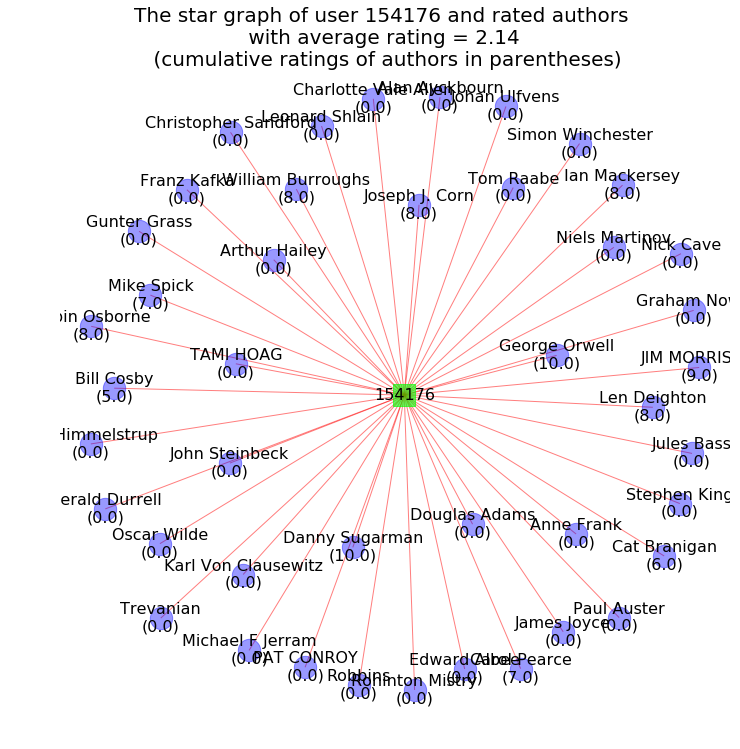

In [29]:
H1=H.subgraph(list(H.neighbors(n1))+[n1])
ara=sum(rn1.values())/float(len(rn1))
labels={}
for i in H1.nodes():
#     labels[i]=i
    if i!=n1:
        labels[i]=unicode(i)+"\n"+"("+str(rn1[i])+")"
    else:
        labels[i]=i
fig = plt.figure(figsize=(12,12))
pos=nx.spring_layout(H1,1.)  #graphviz_layout(H1)
nx.draw_networkx_nodes(H1,pos=pos,nodelist=[n1],node_color='lime',node_shape="s",node_size=500,font_size=20,alpha=0.6);
nx.draw_networkx_nodes(H1,pos=pos,nodelist=list(H.neighbors(n1)),node_color='b',node_size=500,font_size=20,alpha=0.4);
nx.draw_networkx_edges(H1,pos=pos,edge_color='r',alpha=0.5);
nx.draw_networkx_labels(H1,pos=pos,labels=labels,font_size=16);
sst="The star graph of user %s and rated authors \n with average rating = %.2f \n (cumulative ratings of authors in parentheses)" %(n1,ara)
fig.suptitle(sst,x=0.5, y=.95, fontsize=20);
plt.axis('off');

### 7. The Graph of Co-Rated Authors by Common Users

**Again this graph is very large and it would be impossible to be plotted with NetworkX. However, one can focus on the books of a particular group of authors and construct the graph of co-rated authors within this group.**

In [30]:
gm=50 # number of random authors
df['bookAuthor']=df['bookAuthor'].str.title()
while True:
    pau=random.sample(authors,gm)
    pau=[a.title() for a in pau]
    pau=[p for p in pau if '"\"' not in pau]
    df1=df.loc[df['bookAuthor'].isin(pau)]
    gu=df1[['userID','bookAuthor','bookRating']].groupby('userID')
    ubd={}
    for user, data in gu:
        bau=data.bookAuthor.unique()
        ubd[user]=len(bau)
    if max(ubd.values())>5:
        break

In [31]:
print len(pau),pau

50 [u'John Fiske', u'Steven Millhauser', u'H. O Anthonio', u'Veronica Black', u'Janny Wurts', u'Judith Jones', u'Paula Payne Hardin', u'Mary P. Taylor', u'Qui-Gon Jinn', u'Erin Kelly', u'Elizabeth Haich', u'Irwin Mayfair', u'Franklin Allen Behrens', u'Alan E. Nourse', u'Cecil Murphey', u'Cyril Kornbluth', u'Wendell Odom', u'Peter Sis', u'Cristophe Andre', u'Mary Beth Crain', u'Victoria Lancelotta', u'John Keats', u'Fontaine Fox', u'Geoffrey Huntington', u'Joyce Milton', u'John Miller', u'John Pawlikowski', u'Ann Weiser Cornell Ph.D.', u'Stan Mack', u'Diane Michelle Crawford', u'Robert Bruce Thompson', u'Prima', u'Jay Bakker', u'Myriam Yvonne Jehenson', u'J. C. Hallman', u'Les Martin', u'Isak Dinesen', u'Stan Defreitas', u'Angela Shelf Medearis', u'Neil Simon', u'John Le Carre', u'Jane Shapiro', u'R F Delderfield', u'Ronald Reich', u'Lon Poole', u'Brian Johnston', u'Jane Isenberg', u'Nancy Varian Berberick', u'Cheryl Richardson', u'Cara Saylor Polk']


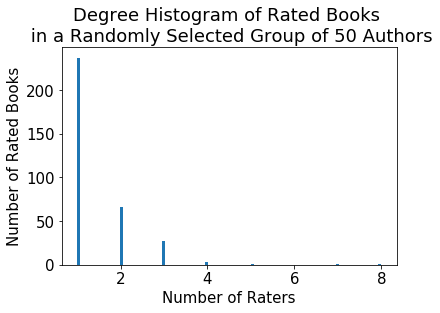

In [32]:
df1=df.loc[df['bookAuthor'].isin(pau)]
gu=df1[['userID','bookAuthor','bookRating']].groupby('userID')
ubd={}
for user, data in gu:
    bau=data.bookAuthor.unique()
    ubd[user]=len(bau)
fbr=[x for x in ubd.values()]
hist(fbr,bins=100);
plt.xlabel("Number of Raters");
plt.ylabel("Number of Rated Books");
sst="Degree Histogram of Rated Books \n in a Randomly Selected Group of %i Authors" %gm
plt.title(sst);

In [33]:
# This dictionary has keys neighbors (i.e., rated authors) 
# of books in the selected group and values their average ratings

rn11={}
gu11=df1.groupby(['bookAuthor','bookRating'])
for name,group in gu11:
    l=group.bookRating.tolist()
    rn11[name[0]] = sum(l) / float(len(l))
print len(rn11)
df11=pd.DataFrame({'Book':rn11.keys(),'Rating':rn11.values()})
df11

50


,Book,Rating
0,Diane Michelle Crawford,0.0
1,Steven Millhauser,9.0
2,Ann Weiser Cornell Ph.D.,0.0
3,John Pawlikowski,0.0
4,Angela Shelf Medearis,10.0
5,Les Martin,10.0
6,Neil Simon,9.0
7,Jay Bakker,6.0
8,Cyril Kornbluth,5.0
9,Isak Dinesen,10.0


In [34]:
edges0=[]
for user, data in gu:
    bau=data.bookAuthor.unique()
    jj=list(itertools.combinations(bau,2))
    for j in jj:
        edges0.append(j)
print len(edges0),len(set(edges0))
edges0
G = nx.Graph()
for k,v in dict(Counter(edges0)).items():
    G.add_edge(k[0],k[1],weight=v)
name="Co-Rated Authors"
first_diagn(G,name)
graph_connectedness_check(G)

224 140
The graph of Co-Rated Authors has 40 nodes and 116 edges
This graph is not connected and the number of connected components = 2
The largest conected component of this graph has 38 nodes and 115 edges


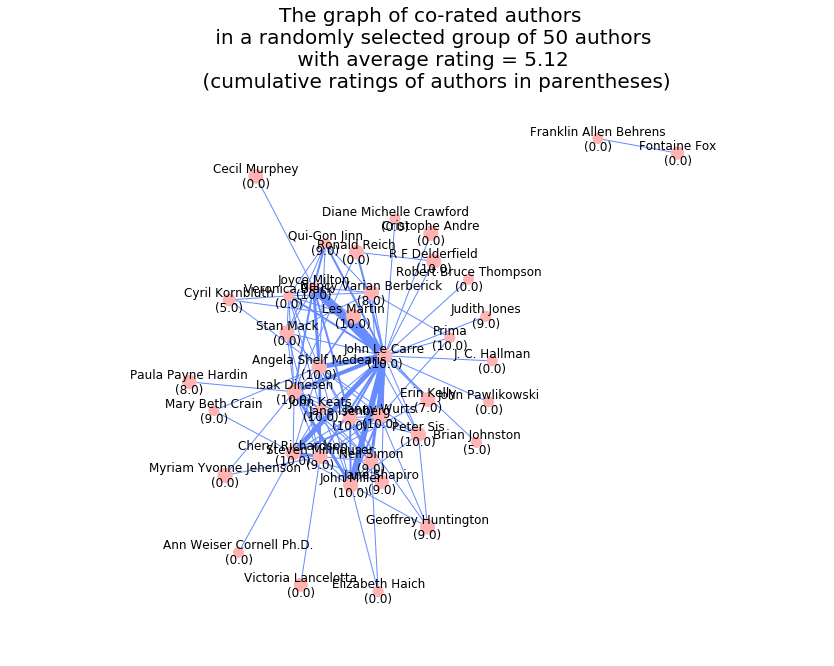

In [35]:
edge_width=[G[u][v]['weight'] for u,v in G.edges()]
# elabels = nx.get_edge_attributes(Gw,'weight')
edge_width=[w for w in edge_width] 
# [math.log(1+w) for w in edge_width]
# [3*w for w in edge_width] 

ara=sum(rn11.values())/float(len(rn11))
labels={}
for i in G.nodes():
    labels[i]=unicode(i)+"\n"+"("+str(rn11[i])+")"

node_size={} 
for i in G.nodes():
    node_size[i]=100+10*rn11[i]
    
figsize=(14,10)
pos=graphviz_layout(G) 
node_color="#ffb3b3"
# node_border_color="grey"
edge_color="#668cff"
# G=Gw

plt.figure(figsize=figsize);
nodes = nx.draw_networkx_nodes(G, pos,node_color=node_color,node_size=node_size.values())
# nodes.set_edgecolor(node_border_color)
nx.draw_networkx_edges(G, pos, edge_color=edge_color,width=edge_width) #,a=0.8)
nx.draw_networkx_labels(G, pos,labels=labels)
# nx.draw_networkx_edge_labels(G,pos,edge_labels=elabels);
plt.axis('off');
# yoffset = {}
# y_off = -10 #0.05  # offset on the y axis
# for k, v in pos.items():
#     yoffset[k] = (v[0], v[1]+y_off)
# nx.draw_networkx_labels(G, yoffset,labels=labels,font_size=14);
sst="The graph of co-rated authors \n in a randomly selected group of %i authors \n with average rating = %.2f \n (cumulative ratings of authors in parentheses)" %(gm,ara)
# sst="The star graph of user %s and rated authors \n with average rating = %.2f \n (cumulative ratings of authors in parentheses)" %(n1,ara)
plt.title(sst,fontsize=20);
plt.margins(x=0.3, y=0.1) 

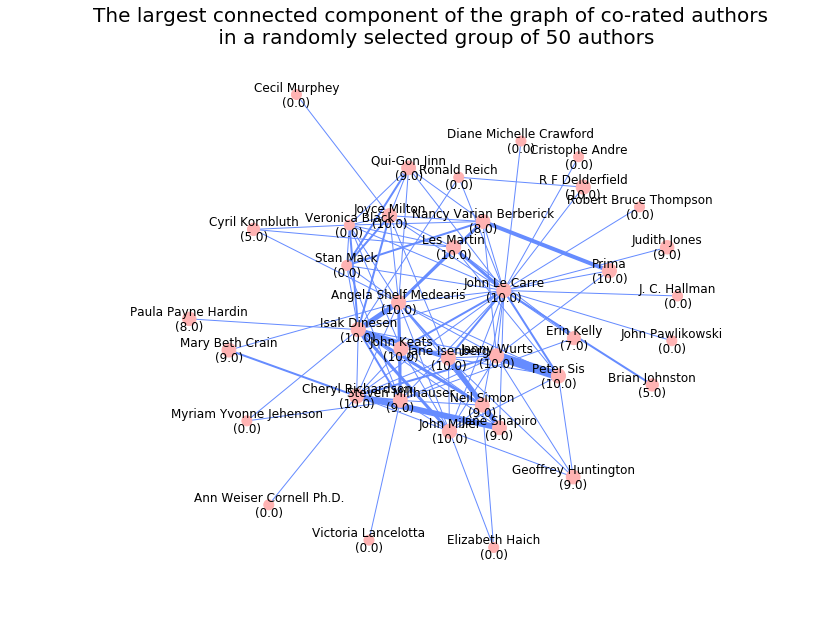

In [36]:
# The larget connected component of the previous graph 
# If the graph is connected, this will be the same as the previous graph

Gl=max(nx.connected_component_subgraphs(G), key=len)
G=Gl
labels={}
for i in G.nodes():
    labels[i]=unicode(i)+"\n"+"("+str(rn11[i])+")"
node_size={} 
for i in G.nodes():
    node_size[i]=100+10*rn11[i]
plt.figure(figsize=figsize);
nodes = nx.draw_networkx_nodes(G, pos,node_color=node_color,node_size=node_size.values())
# nodes.set_edgecolor(node_border_color)
nx.draw_networkx_edges(G, pos, edge_color=edge_color,width=edge_width) #,a=0.8)
nx.draw_networkx_labels(G, pos,labels=labels)
# nx.draw_networkx_edge_labels(G,pos,edge_labels=elabels);
plt.axis('off');
# yoffset = {}
# y_off = -10 #0.05  # offset on the y axis
# for k, v in pos.items():
#     yoffset[k] = (v[0], v[1]+y_off)
# nx.draw_networkx_labels(G, yoffset,font_size=14);
sst="The largest connected component of the graph of co-rated authors \n in a randomly selected group of %i authors" %gm
plt.title(sst,fontsize=20);
plt.margins(x=0.3, y=0.1)